# Time Series
## Introduction
Until now, the only sequence data we’ve covered have been text data, such as the IMDB dataset and the Reuters dataset. But sequence data is found in many more problems than just language processing. You will now use weather time-series dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany. We will carefully go through an example presented by F. Chollet in his book Deep Learning with Python and compare how different types of networks solve the time-series prediction problem.

### Download data
In this dataset, 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical time-series. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worths of data points) and predicts the air temperature 24 hours in the future.

Download data from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

Extract data to one of your directories, load them and check if they are correct.

In [29]:
data = open('lesson_10_data/jena_climate_2009_2016.csv/jena_climate_2009_2016.csv').read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

recording_interval_in_minutes = 10

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps?

You’ll use the following parameter values:
- lookback = 720 — Observations will go back 5 days.
- steps = 6 — Observations will be sampled at one data point per hour.
- delay = 144 — Targets will be 24 hours in the future.

### Explore dataset
To get started, you need to do two things:
- Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, the temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.
- Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data. You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

First, parse the data:

In [30]:
import numpy as np
 
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


In [31]:
# create a dictionary of column indices for each column name without the first column (date)
column_indices = {name: i for i, name in enumerate(header[1:])}
column_indices

{'"p (mbar)"': 0,
 '"T (degC)"': 1,
 '"Tpot (K)"': 2,
 '"Tdew (degC)"': 3,
 '"rh (%)"': 4,
 '"VPmax (mbar)"': 5,
 '"VPact (mbar)"': 6,
 '"VPdef (mbar)"': 7,
 '"sh (g/kg)"': 8,
 '"H2OC (mmol/mol)"': 9,
 '"rho (g/m**3)"': 10,
 '"wv (m/s)"': 11,
 '"max. wv (m/s)"': 12,
 '"wd (deg)"': 13}

As we are interested only in the temperature, extract it from the whole set of 14 variables. To understand the problem better you can plot the whole series or some specific parts of it:

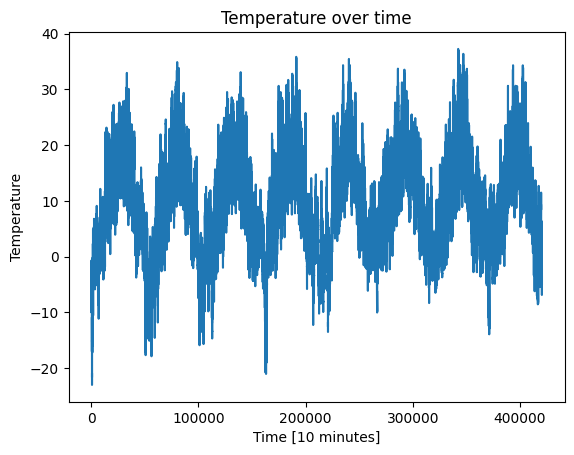

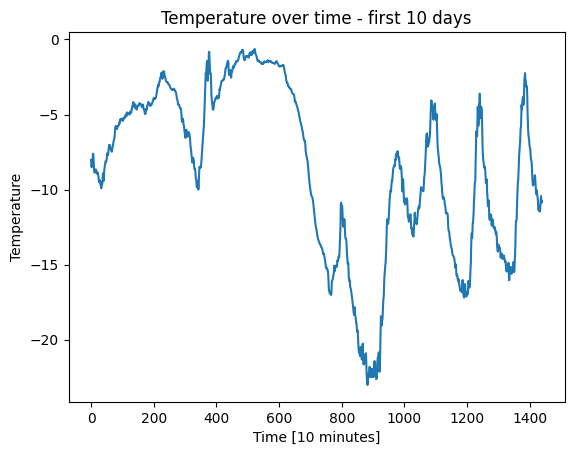

In [32]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
 
#TODO: Plot whole temperature series, notice yearly trends
plt.plot(range(len(temp)), temp)
plt.title('Temperature over time')
plt.ylabel('Temperature')
plt.xlabel('Time [10 minutes]')
plt.show()

DAYS = 10
SAMPLES_PER_DAY = (24 * 60) // recording_interval_in_minutes
SAMPLES = DAYS * SAMPLES_PER_DAY

#TODO: Plot the first few days
plt.plot(range(SAMPLES), temp[:SAMPLES])
plt.title(f'Temperature over time - first {DAYS} days')
plt.ylabel('Temperature')
plt.xlabel('Time [10 minutes]')
plt.show()

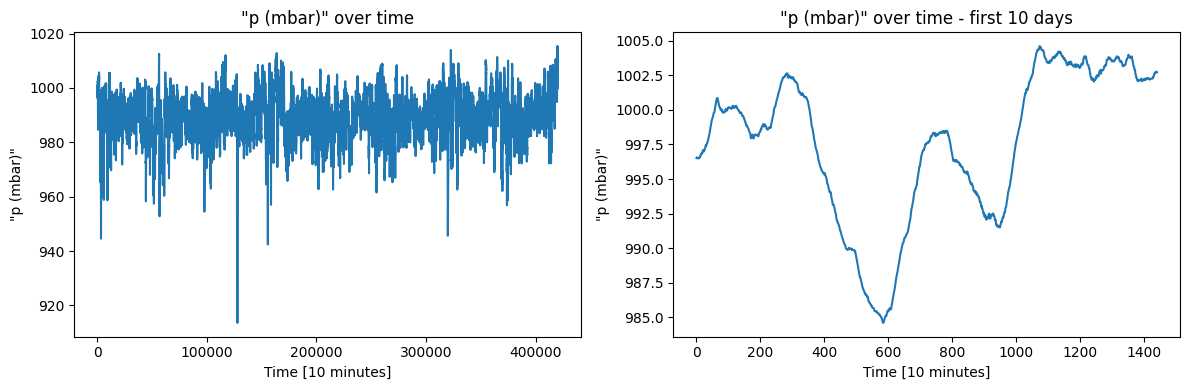

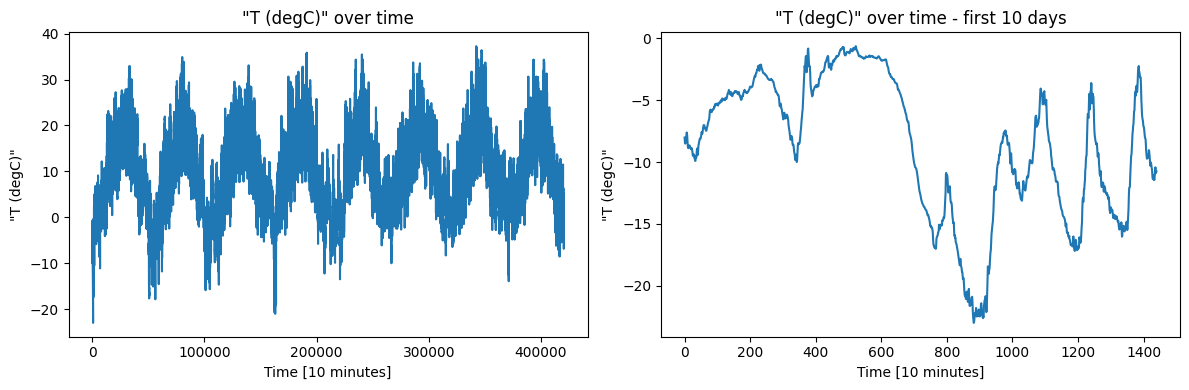

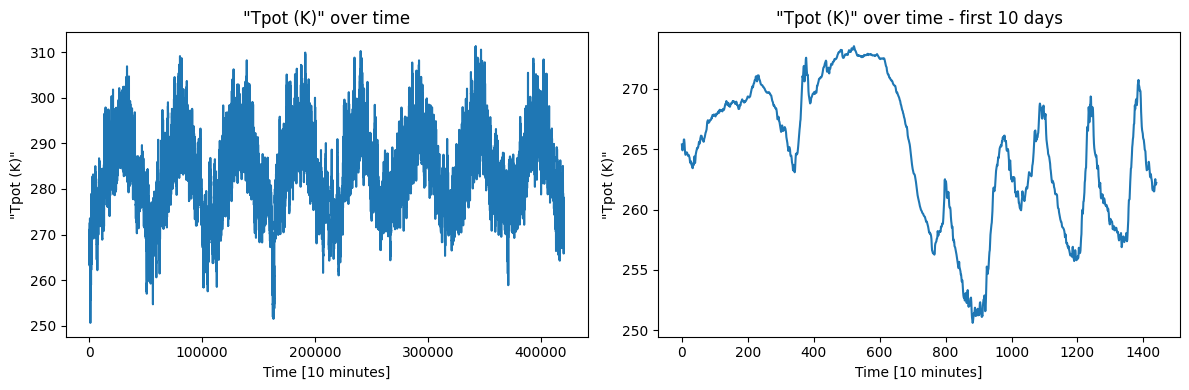

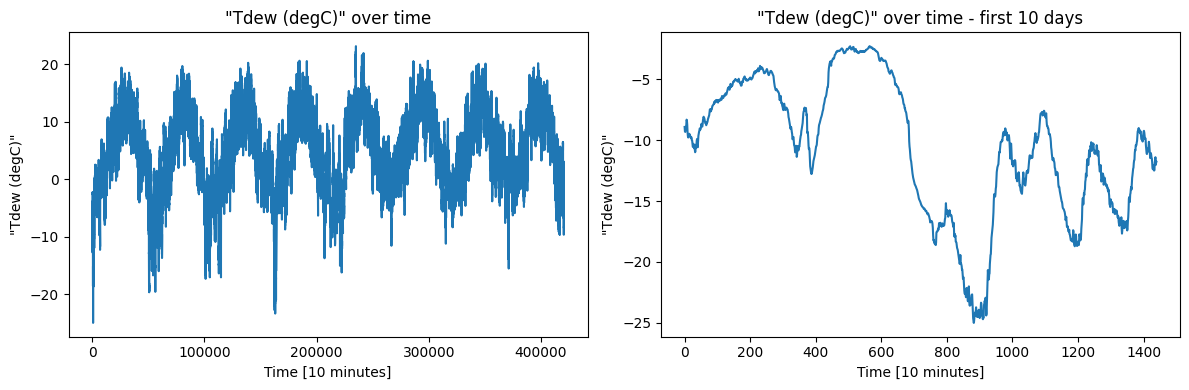

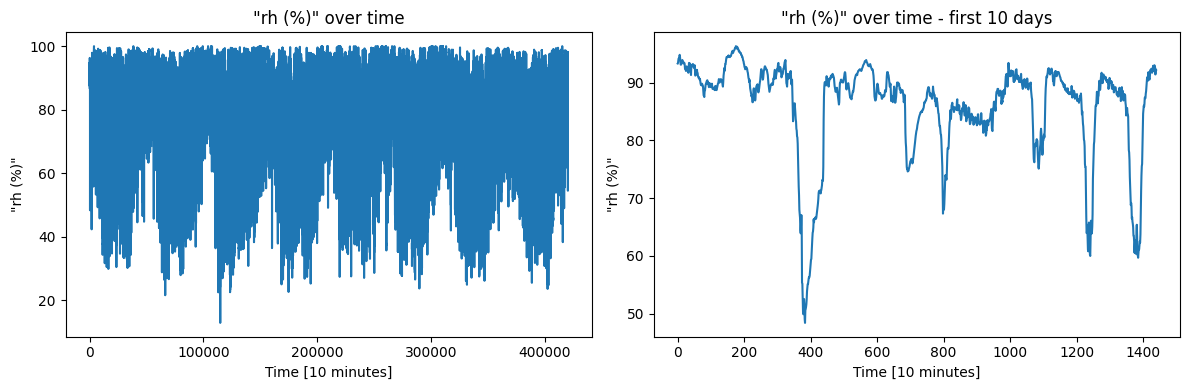

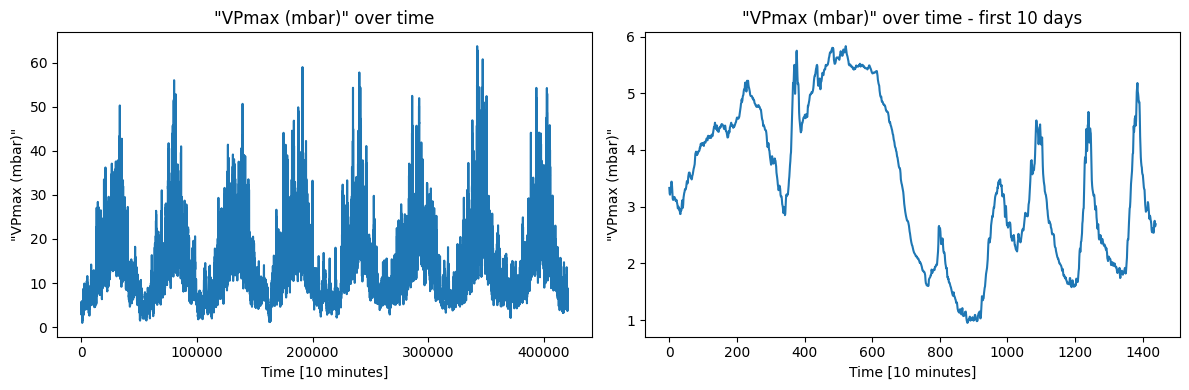

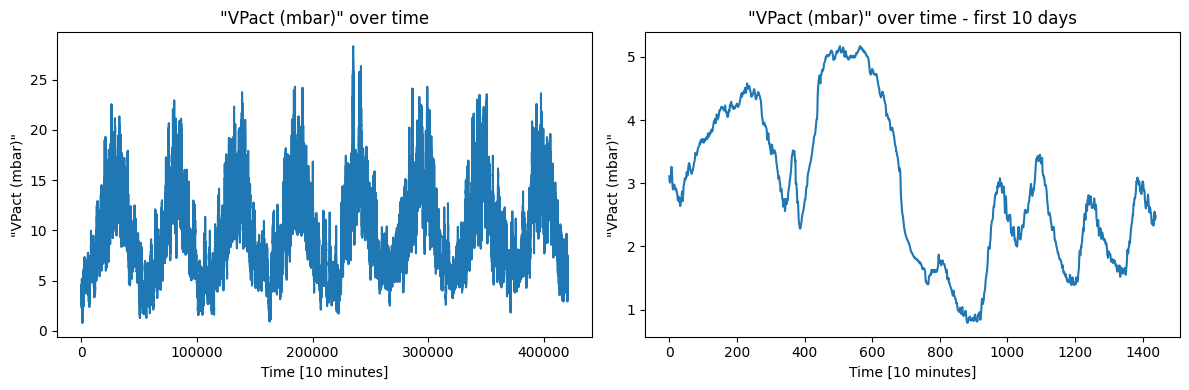

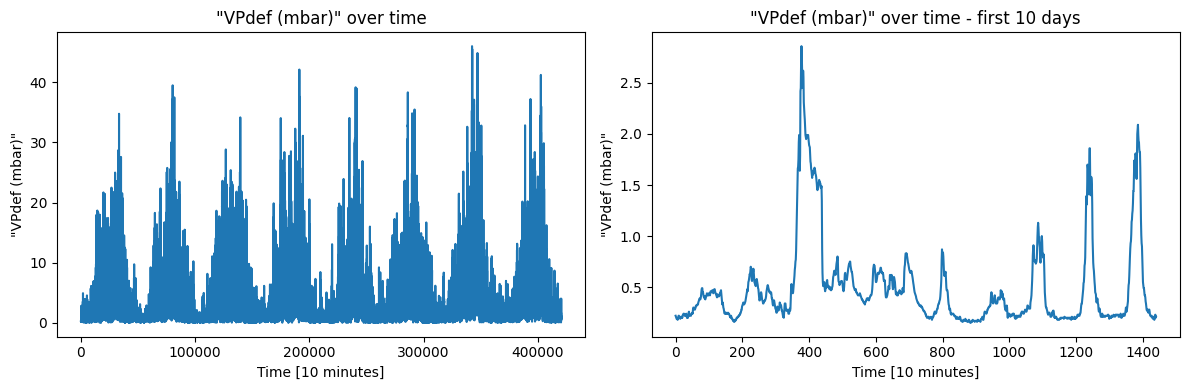

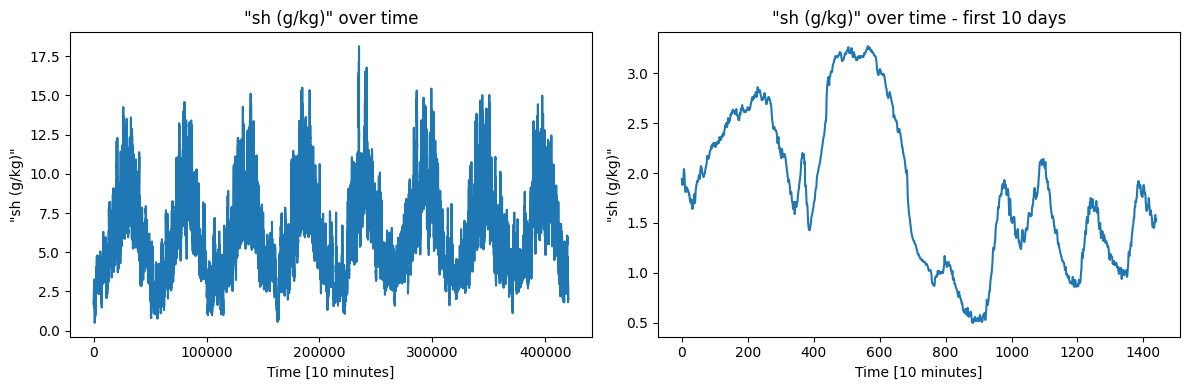

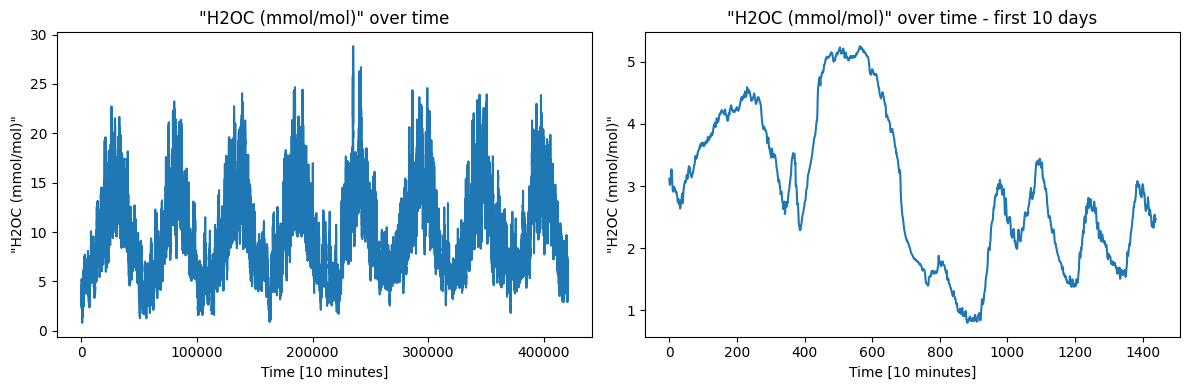

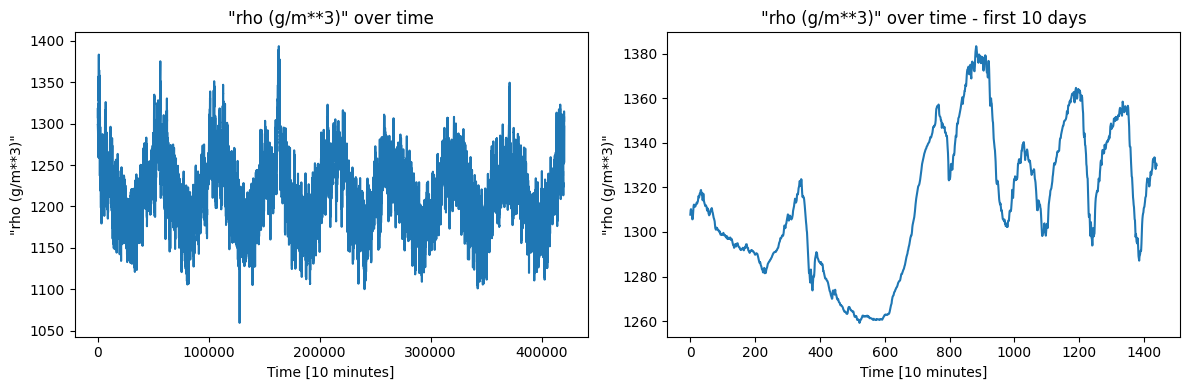

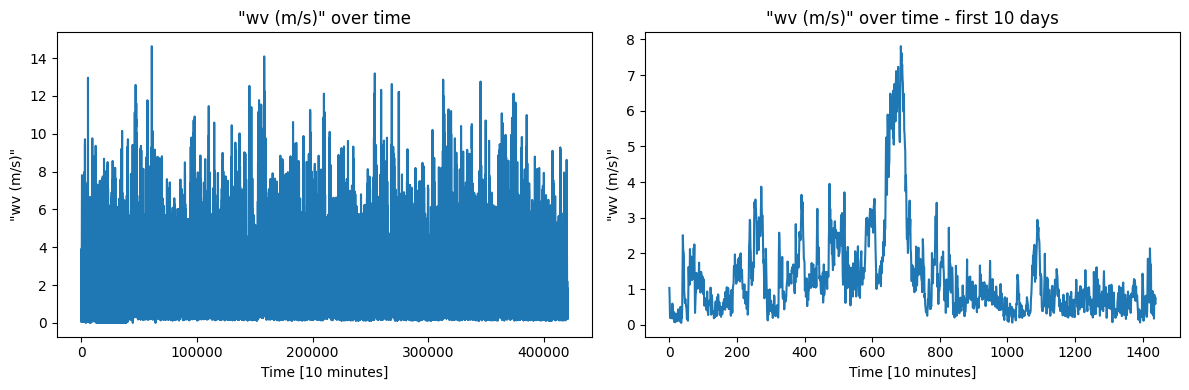

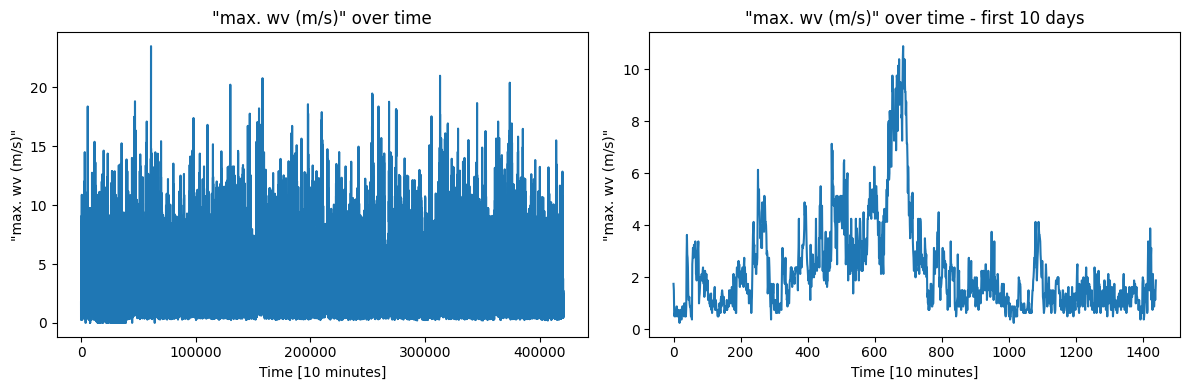

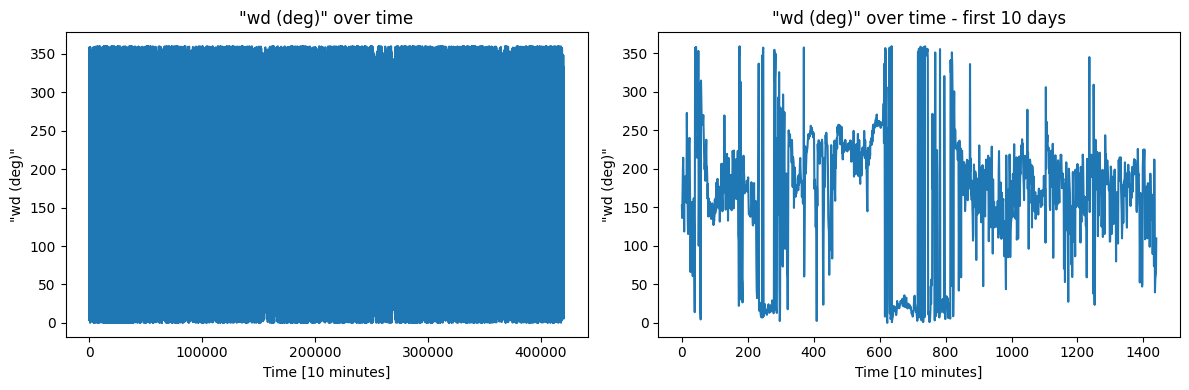

In [33]:
for name, column_index in column_indices.items():
    # Set up subplots with 1 row and 2 columns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot all columns for all days
    axes[0].plot(float_data[:, column_index])
    axes[0].set_title(f'{name} over time')
    axes[0].set_ylabel(name)
    axes[0].set_xlabel('Time [10 minutes]')

    # Plot all columns for the first few days
    axes[1].plot(range(SAMPLES), float_data[:SAMPLES, column_index])
    axes[1].set_title(f'{name} over time - first {DAYS} days')
    axes[1].set_ylabel(name)
    axes[1].set_xlabel('Time [10 minutes]')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

Normalize the data by subtracting the mean and dividing by the standard deviation (calculated on a train set (first 200000 samples)):

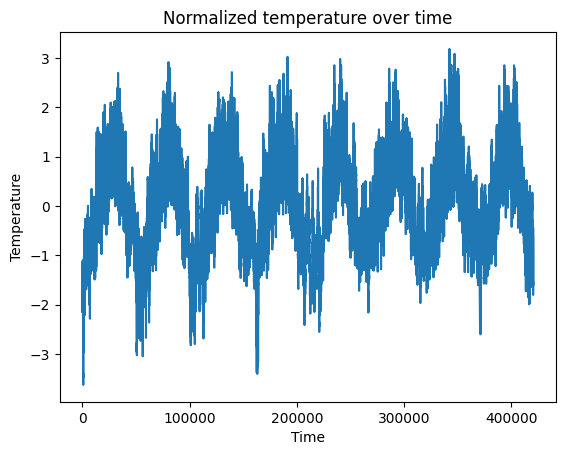

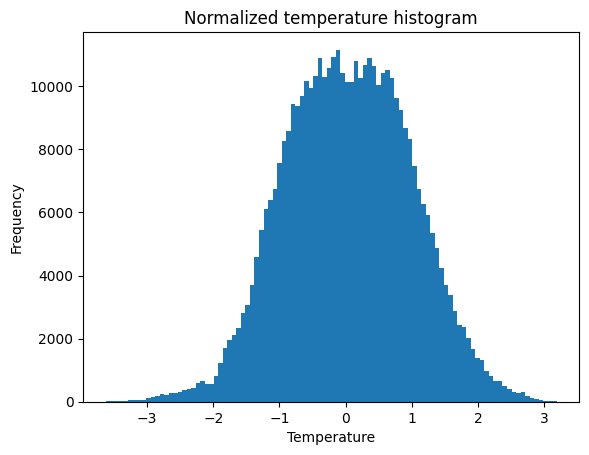

In [34]:
#TODO: Normalize the data
# Normalize the data by subtracting the mean and dividing by the standard deviation (calculated on a train set (first 200000 samples)):
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# plot the normalized data - e.g. temp
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.title('Normalized temperature over time')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.show()

# plot histogram of temperature
plt.hist(temp, bins=100)
plt.title('Normalized temperature histogram')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

The normalization should be done for all 14 variables independently, not only for temperature. We predict only one parameter (target - y), but analyse all of them (input - x).

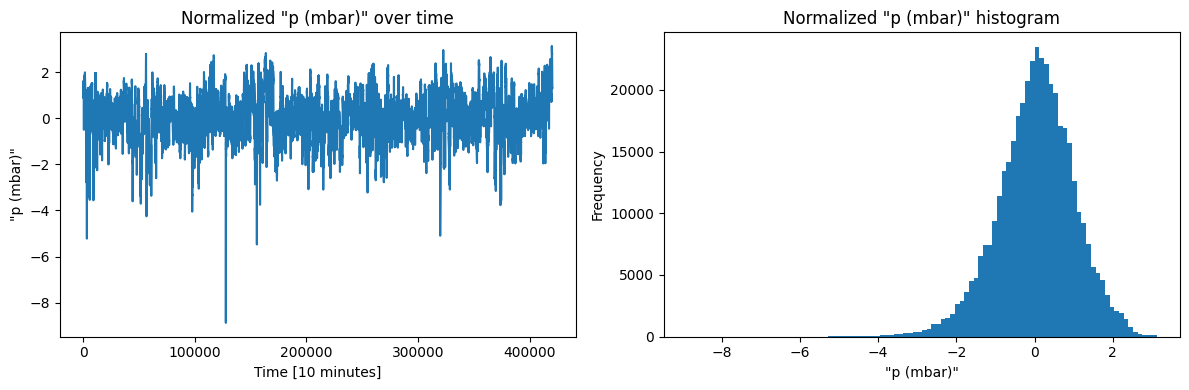

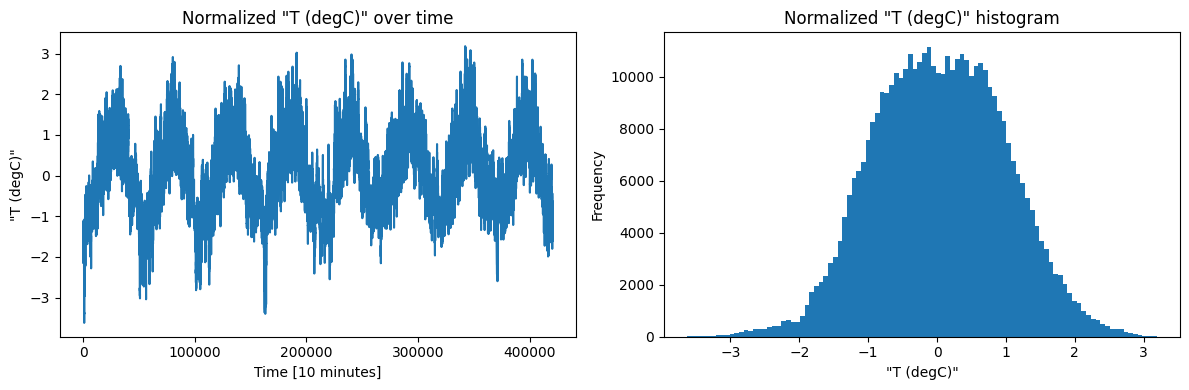

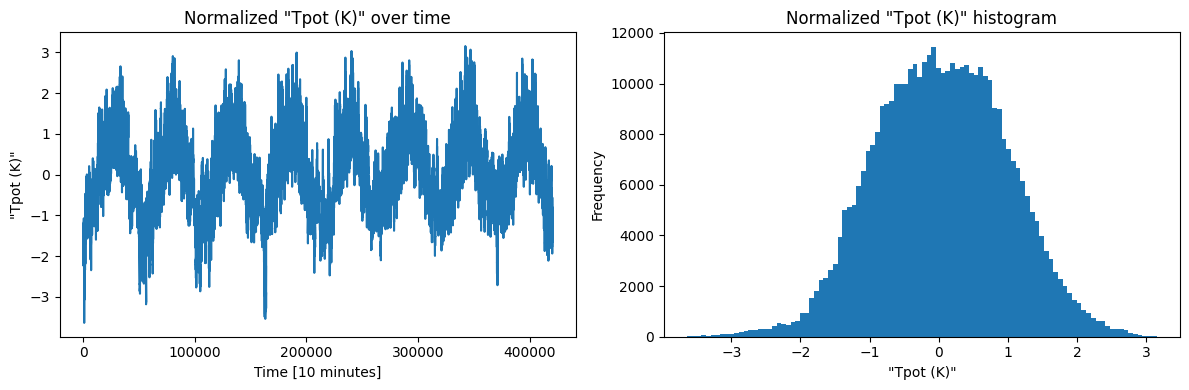

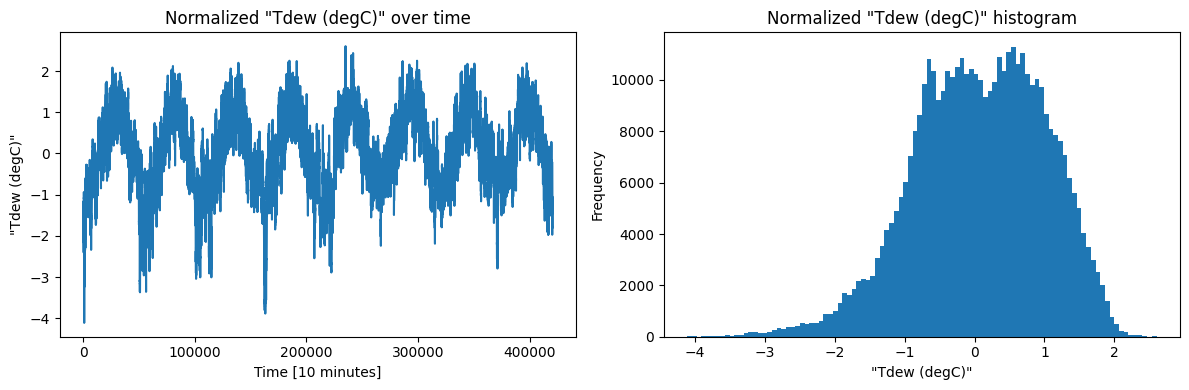

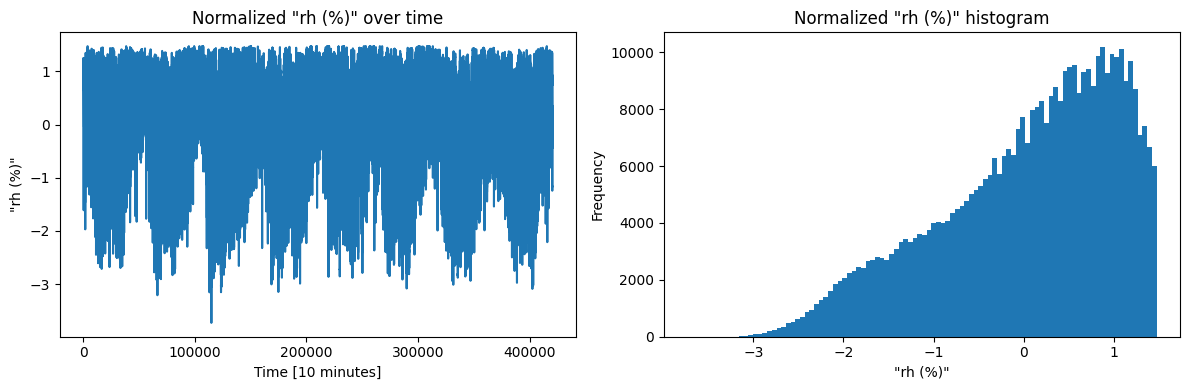

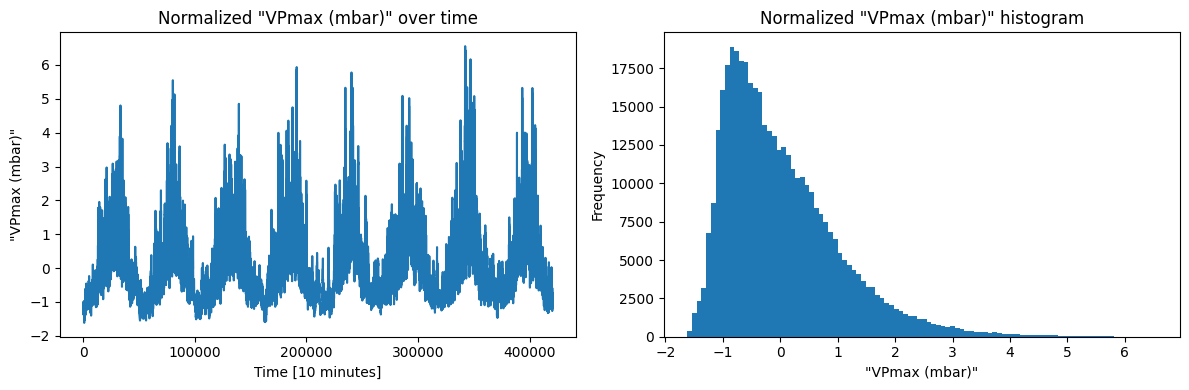

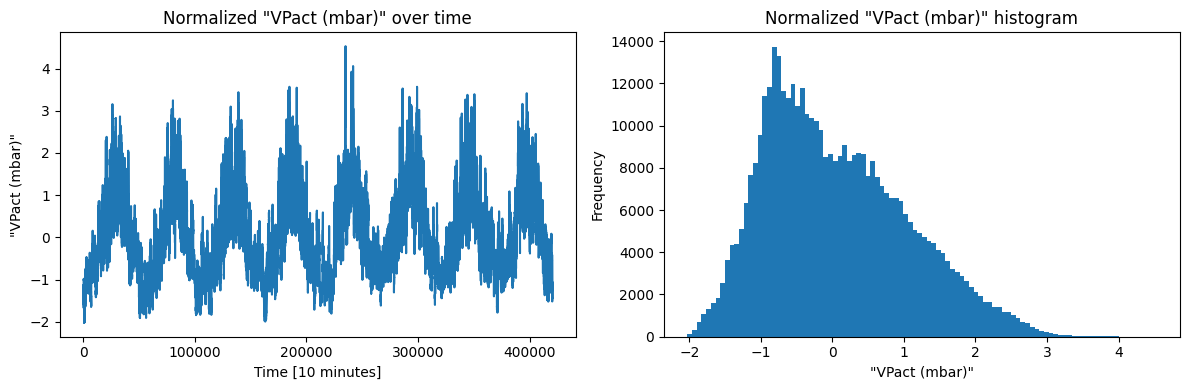

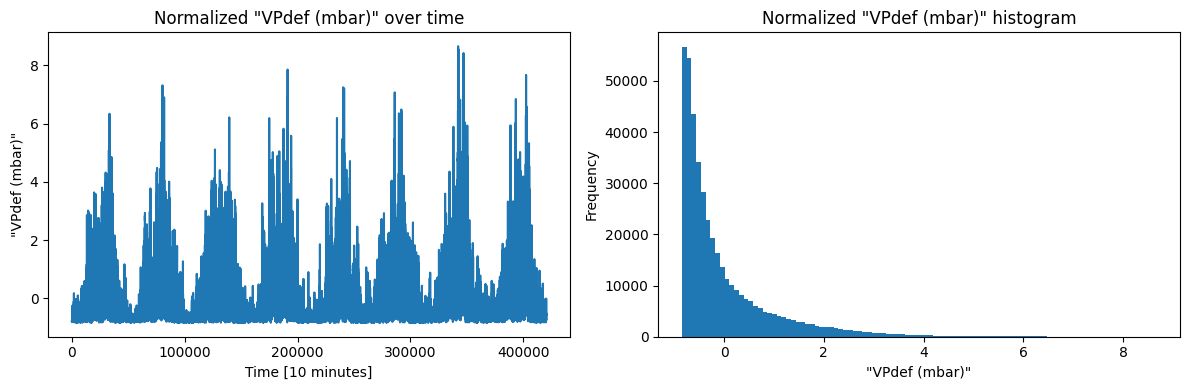

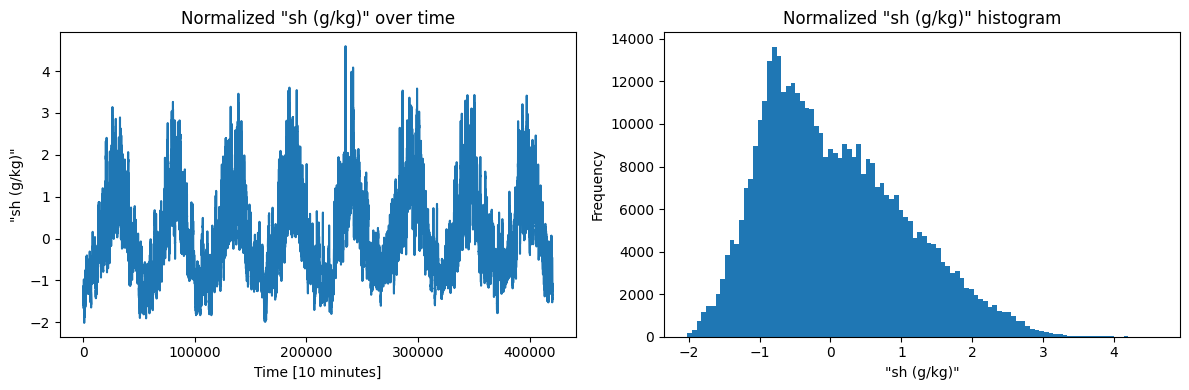

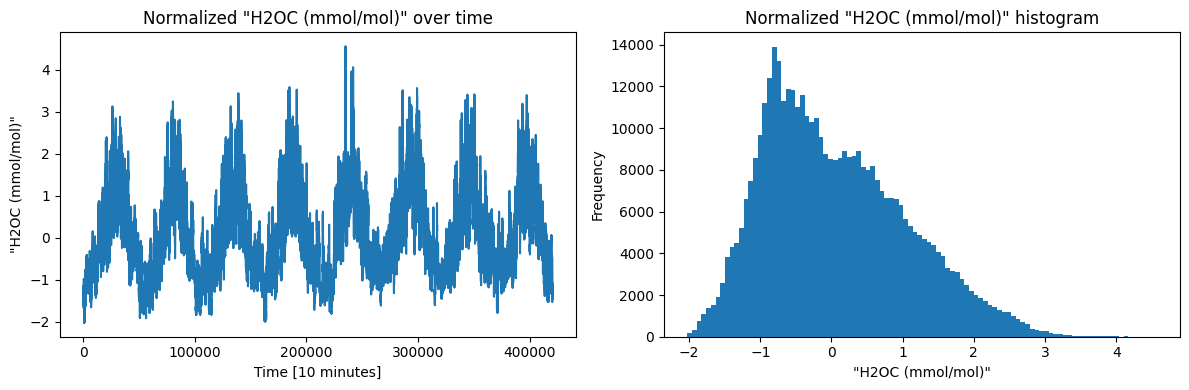

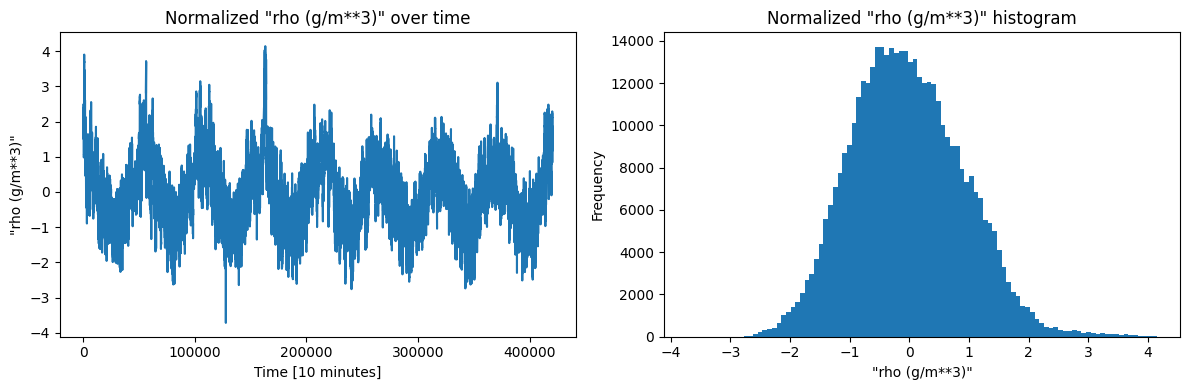

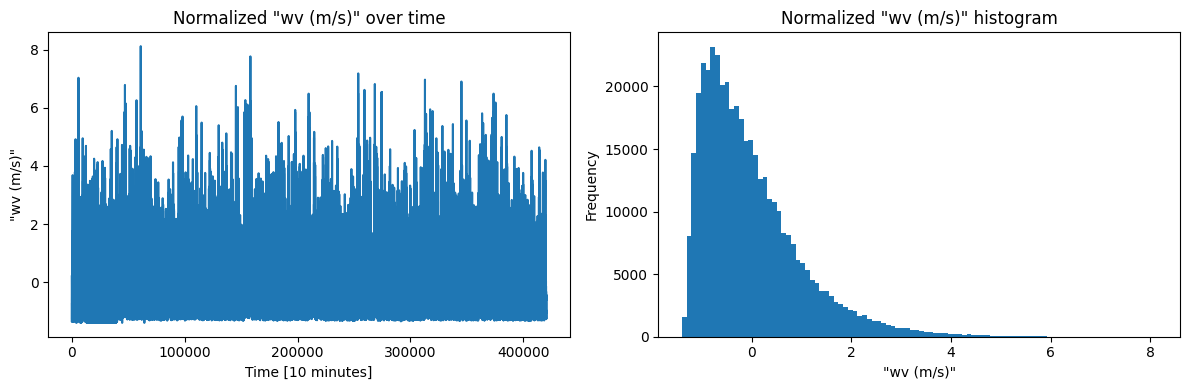

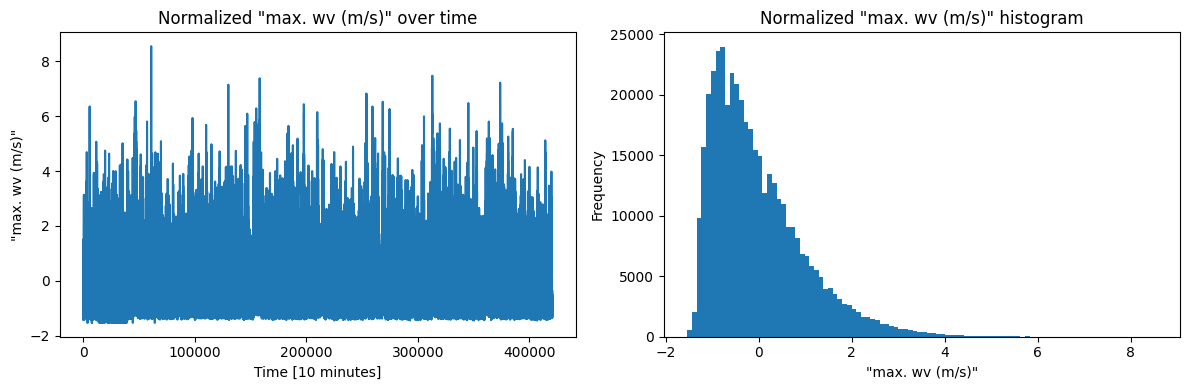

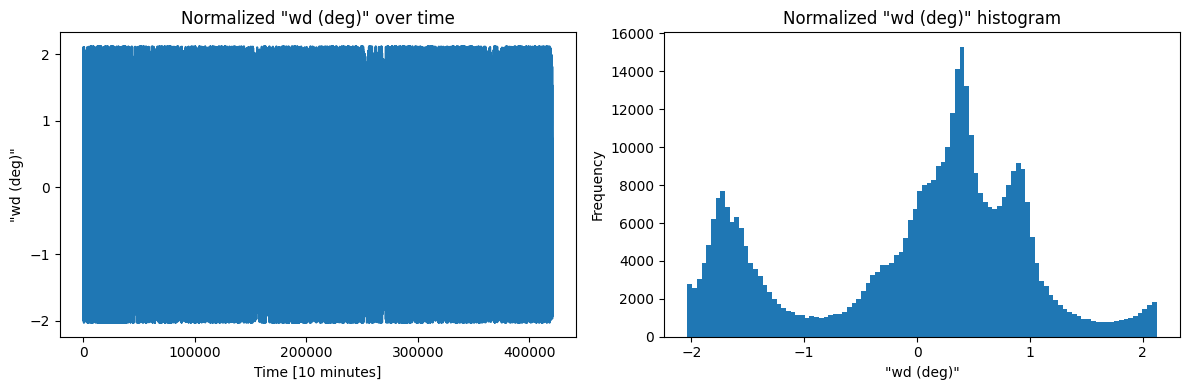

In [36]:
# Plot normalized data
for name, column_index in column_indices.items():
    # Set up subplots with 1 row and 2 columns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    # Plot all columns for all days
    axes[0].plot(float_data[:, column_index])
    axes[0].set_title(f'Normalized {name} over time')
    axes[0].set_ylabel(name)
    axes[0].set_xlabel('Time [10 minutes]')
    
    # Plot histogram of all columns
    axes[1].hist(float_data[:, column_index], bins=100)
    axes[1].set_title(f'Normalized {name} histogram')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlabel(name)

    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### Set up data generators
Now, let’s use the abstract generator function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [37]:
# generator function used to feed the training, validation and test data
def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
 
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Let's now define lookback, step, delay parameters and set generators. In the example, batch_size = 128 was used, but you can try with different values.

In [40]:
#TODO Define lookback, step, delay and batch size variable
# - lookback = 720 — Observations will go back 5 days.
# - steps = 6 — Observations will be sampled at one data point per hour.
# - delay = 144 — Targets will be 24 hours in the future.
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
 
#TODO: Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

#TODO: Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

> **_NOTE:_**: Useful info (last update on 20.12.2023):
> * You should expect a loss value in range 0,2-0,4 for both training and validation. 0,4 is quite bad. 0,3 is ok. 0,2 on a training set means overfitting, on validation it will be almost impossible to get.
> * You should expect a huge overfitting. Some results won't be good at all - validation will not improve in some cases.
> * The best results will probably come from a GRU layers with added dropout.
> * The fastest training should be achieved with conv1D
> * Make sure to set a steps_per_epoch and validation_step parameters. Some keras functions like ImageDataGenerator allow for skipping this parameter and set it automatically. However, in this task we have our own generator which will run indefinitely if we do not stop it.
> * Make sure to normalize the data for each variable, not only for a temperature.
> * Make sure to shuffle data only in a train generator.
> * In some cases specifying a batch_size twice (in a generator and in model.fit) might cause an error.
> * You should not see any regular oscilations in the validation loss. Such behaviour on the loss plot indicates some errors. Possibly with steps_per_epoch parameter.

#### Basic approach
We will start with a basic approach that uses no recurrent layers. It probably won't work well, but will serve as a reference point. The following section shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

In [43]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 32)                53792     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53825 (210.25 KB)
Trainable params: 53825 (210.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
from keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size 

#TODO: Train the network for about 20 epochs
model.fit(train_gen,
          steps_per_epoch=500,
          epochs=20,
          validation_data=val_gen,
          validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 6s 11ms/step - loss: 0.7612 - val_loss: 0.4857
Epoch 2/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3430 - val_loss: 0.3372
Epoch 3/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2872 - val_loss: 0.2817
Epoch 4/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2705 - val_loss: 0.2905
Epoch 5/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2597 - val_loss: 0.2908
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.2524 - val_loss: 0.2995
Epoch 7/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2482 - val_loss: 0.2889
Epoch 8/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2428 - val_loss: 0.3088
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2393 - val_loss: 0.3057
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2358 - val_lo

In [48]:
def plot_metric(history_dict, metric):
    plt.clf()  # clear figure
    loss_values = history_dict[metric]
    val_loss_values = history_dict[f'val_{metric}']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'go', label=f'Training {metric}')
    plt.plot(epochs, val_loss_values, 'bo', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

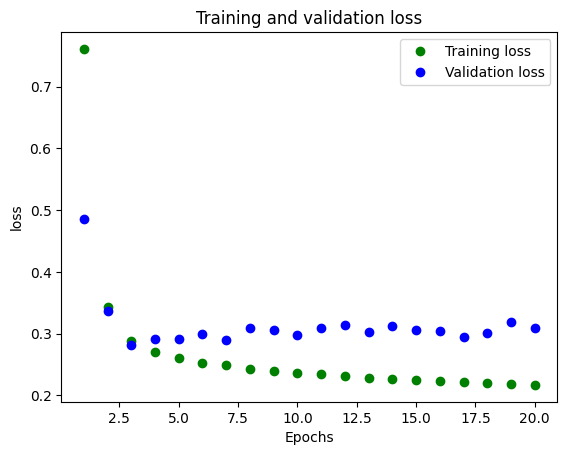

In [49]:
#TODO: Plot the results
history_dict = model.history.history
plot_metric(history_dict, 'loss')

#### GRU layer
Instead of the LSTM layer introduced in the previous lab, you’ll use the GRU layer, developed by [Chung et al. in 2014](https://arxiv.org/abs/1412.3555). Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM).



In [50]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4608      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train this network for about 20 epochs and plot the results.

In [52]:
model.compile(optimizer=RMSprop(), loss='mae')

model.fit(train_gen,
          steps_per_epoch=500,
          epochs=20,
          validation_data=val_gen,
          validation_steps=val_steps)

Epoch 1/20


500/500 [==============================] - 41s 78ms/step - loss: 0.2795 - val_loss: 0.2695
Epoch 2/20
500/500 [==============================] - 36s 72ms/step - loss: 0.2745 - val_loss: 0.2688
Epoch 3/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2683 - val_loss: 0.2667
Epoch 4/20
500/500 [==============================] - 39s 78ms/step - loss: 0.2663 - val_loss: 0.2662
Epoch 5/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2614 - val_loss: 0.2665
Epoch 6/20
500/500 [==============================] - 42s 85ms/step - loss: 0.2568 - val_loss: 0.2680
Epoch 7/20
500/500 [==============================] - 36s 72ms/step - loss: 0.2529 - val_loss: 0.2696
Epoch 8/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2489 - val_loss: 0.2706
Epoch 9/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2446 - val_loss: 0.2735
Epoch 10/20
500/500 [==============================] - 40s 80ms/step - loss: 0.2412 - val_los

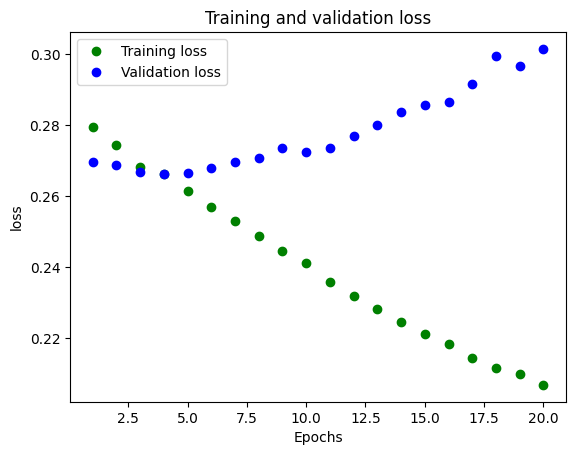

In [54]:
history_dict = model.history.history
plot_metric(history_dict, 'loss')

You can also try stacking several GRU layers on each other, or adding dropout and recurrent dropout to the GRU layer. In this case train it a bit longer (aboout 40 epochs):

In [57]:
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 32)                4608      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(optimizer=RMSprop(), loss='mae')

model.fit(train_gen,
          steps_per_epoch=500,
          epochs=40,
          validation_data=val_gen,
          validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 58s 112ms/step - loss: 0.3223 - val_loss: 0.2805
Epoch 2/40
500/500 [==============================] - 57s 114ms/step - loss: 0.3079 - val_loss: 0.2733
Epoch 3/40
500/500 [==============================] - 55s 110ms/step - loss: 0.3025 - val_loss: 0.2713
Epoch 4/40
500/500 [==============================] - 55s 111ms/step - loss: 0.2973 - val_loss: 0.2702
Epoch 5/40
500/500 [==============================] - 60s 120ms/step - loss: 0.2923 - val_loss: 0.2660
Epoch 6/40
500/500 [==============================] - 61s 121ms/step - loss: 0.2883 - val_loss: 0.2681
Epoch 7/40
500/500 [==============================] - 54s 108ms/step - loss: 0.2859 - val_loss: 0.2708
Epoch 8/40
500/500 [==============================] - 63s 126ms/step - loss: 0.2822 - val_loss: 0.2737
Epoch 9/40
500/500 [==============================] - 56s 113ms/step - loss: 0.2812 - val_loss: 0.2717
Epoch 10/40
500/500 [==============================] - 58s 116ms/step - l

In [ ]:
history_dict = model.history.history
plot_metric(history_dict, 'loss')

#### Bidirectional GRU layer
A bidirectional recurrent neural network exploits the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

In [60]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 64)                9216      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9281 (36.25 KB)
Trainable params: 9281 (36.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Try training bidirectional GRU for about 40 epochs, but don't expect much improvement vs simple GRU. In this example reversing data order does not carry much information, but keep in mind that this is possible and might sometimes be useful.

In [61]:
model.compile(optimizer=RMSprop(), loss='mae')

model.fit(train_gen,
          steps_per_epoch=500,
          epochs=40,
          validation_data=val_gen,
          validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 35s 64ms/step - loss: 0.2917 - val_loss: 0.2756
Epoch 2/40
500/500 [==============================] - 54s 108ms/step - loss: 0.2746 - val_loss: 0.2755
Epoch 3/40
500/500 [==============================] - 59s 118ms/step - loss: 0.2700 - val_loss: 0.2681
Epoch 4/40
500/500 [==============================] - 45s 90ms/step - loss: 0.2642 - val_loss: 0.2732
Epoch 5/40
500/500 [==============================] - 45s 90ms/step - loss: 0.2587 - val_loss: 0.2655
Epoch 6/40
500/500 [==============================] - 50s 101ms/step - loss: 0.2555 - val_loss: 0.2642
Epoch 7/40
500/500 [==============================] - 48s 96ms/step - loss: 0.2487 - val_loss: 0.2681
Epoch 8/40
500/500 [==============================] - 50s 99ms/step - loss: 0.2426 - val_loss: 0.2682
Epoch 9/40
500/500 [==============================] - 53s 107ms/step - loss: 0.2366 - val_loss: 0.2730
Epoch 10/40
500/500 [==============================] - 51s 103ms/step - loss: 

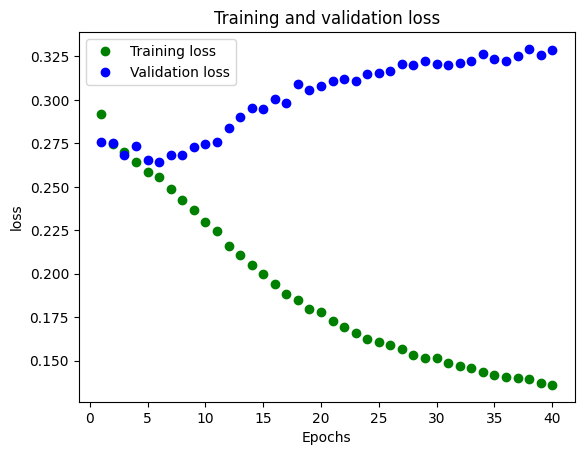

In [62]:
history_dict = model.history.history
plot_metric(history_dict, 'loss')

#### Conv1D layers
ConvNets, we worked on before, extracted local features and allow for representation modularity. The same properties that make them excel at computer vision also make them highly relevant to sequence processing. They can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost.

2D convolution layers extract patches from image tensors and apply an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized in a different position.

![1D convolutions](images/lesson_10_cnn1d_new.png)

In [63]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          2272      
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_8 (GRU)                 (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793 (53.88 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

Train this network for about 20 epochs.

In [64]:
model.compile(optimizer=RMSprop(), loss='mae')

model.fit(train_gen,
          steps_per_epoch=500,
          epochs=20,
          validation_data=val_gen,
          validation_steps=val_steps)

Epoch 1/20


500/500 [==============================] - 31s 55ms/step - loss: 0.3395 - val_loss: 0.3106
Epoch 2/20
500/500 [==============================] - 24s 49ms/step - loss: 0.3071 - val_loss: 0.3213
Epoch 3/20
500/500 [==============================] - 25s 51ms/step - loss: 0.2930 - val_loss: 0.3071
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.2836 - val_loss: 0.2941
Epoch 5/20
500/500 [==============================] - 27s 53ms/step - loss: 0.2733 - val_loss: 0.2934
Epoch 6/20
500/500 [==============================] - 25s 50ms/step - loss: 0.2654 - val_loss: 0.2993
Epoch 7/20
500/500 [==============================] - 26s 51ms/step - loss: 0.2577 - val_loss: 0.2990
Epoch 8/20
500/500 [==============================] - 29s 58ms/step - loss: 0.2526 - val_loss: 0.3001
Epoch 9/20
500/500 [==============================] - 28s 55ms/step - loss: 0.2462 - val_loss: 0.3040
Epoch 10/20
500/500 [==============================] - 30s 60ms/step - loss: 0.2414 - val_los

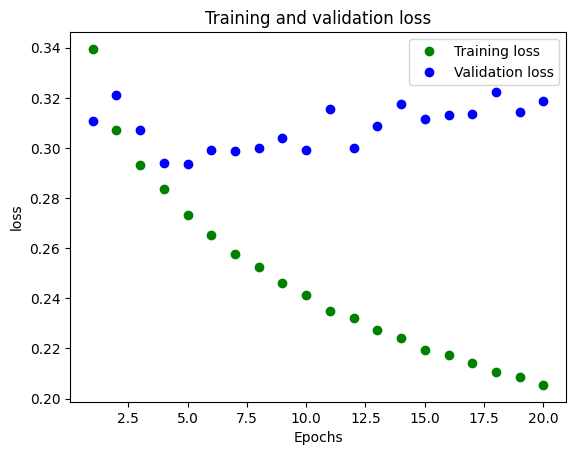

In [65]:
history_dict = model.history.history
plot_metric(history_dict, 'loss')

## Lab Sources
This lab was based on the book Deep Learning with Python by F.Chollet. Fragments of the code (with some modifications) are available also in the:
- [this Notebook](https://www.kaggle.com/pankrzysiu/6-3-1-a-temperature-forecasting-problem),
- [Tensorflow Website](https://www.tensorflow.org/tutorials/structured_data/time_series), 
- or [Keras Website](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).